In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
from tensorflow import keras
from keras.layers import ReLU, Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from keras.layers import Input, concatenate, Conv2D, Flatten, Dropout
from keras import Model
from IPython.display import display
from keras.models import save_model, load_model
import PIL
# from google.colab import files

In [14]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [17]:
# Convert pixel values to floating-point
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Calculate normalization factors
max_value = np.max(train_images)  # Get the maximum pixel value from the training set

# Normalize the images
train_images /= max_value
test_images /= max_value

In [6]:
# def img_to_float(img):
#     return (np.float32(img) - 127.5) / 127.5

# def img_to_uint8(img):
#     return np.uint8(img * 127.5 + 128).clip(0, 255)


# train_img_f32 = img_to_float(train_images)
# BUFFER_SIZE = train_img_f32.shape[0]
# BATCH_SIZE = 100
# train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels[:, 0]).map(lambda y: tf.one_hot(y, 10))
# train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
# train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# latent_dim = 100

In [7]:
def img_to_float(img):
    return (np.float32(img) - 127.5) / 127.5

def img_to_uint8(img):
    return np.uint8(img * 127.5 + 128).clip(0, 255)

def one_hot_encode_label(label):
    return tf.one_hot(label, 10)

train_img_f32 = img_to_float(train_images)
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 100
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels[:, 0]).map(one_hot_encode_label)
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
latent_dim = 100

In [8]:
def build_generator():
    input_latent = Input((latent_dim,))
    input_labels = Input((10,))
    generator_input = concatenate([input_latent, input_labels])

    gen_model = Dense(4 * 4 * 256, use_bias=False)(generator_input)
    gen_model = ReLU()(gen_model)
    gen_model = Reshape((4, 4, 256))(gen_model)
    gen_model = Conv2DTranspose(192, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(96, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False)(gen_model)
    gen_model = BatchNormalization()(gen_model)
    gen_model = ReLU()(gen_model)
    gen_model = Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(gen_model)
    # gen_model = BatchNormalization()(gen_model)
    # gen_model = ReLU()(gen_model)
    # gen_model = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')(gen_model)

    generator = Model(inputs=[input_latent, input_labels], outputs=gen_model)
    return generator

def build_discriminator():
    discriminator_input = Input((32, 32, 3))
    disc_model = Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same')(discriminator_input)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)
    
    disc_model = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(disc_model)
    disc_model = BatchNormalization()(disc_model)
    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    disc_model = Dropout(0.5)(disc_model)

    disc_model = Flatten()(disc_model)
    disc_output_d = Dense(1)(disc_model)
    disc_output_c = Dense(10)(disc_model)

    discriminator = Model(inputs=discriminator_input, outputs=[disc_output_d, disc_output_c])
    return discriminator

def generator_loss(generated_output, labels):
    out_d, out_c = generated_output
    loss_d = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(out_d), out_d)
    loss_c = tf.losses.CategoricalCrossentropy(from_logits=True)(labels, out_c)
    return loss_d + loss_c

def discriminator_loss(real_output, generated_output, labels):
    real_out_d, real_out_c = real_output
    real_loss_d = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_out_d), real_out_d)
    real_loss_c = tf.losses.CategoricalCrossentropy(from_logits=True)(labels, real_out_c)
    real_loss = real_loss_d + real_loss_c

    generated_out_d, generated_out_c = generated_output
    generated_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_out_d), generated_out_d)
    total_loss = real_loss + generated_loss

    return total_loss

generator = build_generator()
discriminator = build_discriminator()

In [ ]:
generator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

tf.autograph.set_verbosity(0, True)
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_output, labels)
        disc_loss = discriminator_loss(real_output, generated_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


EPOCHS = 450
num_examples_to_generate = 20

random_vector_for_generation = tf.random.normal([num_examples_to_generate, latent_dim])
condition_vector_generation = tf.one_hot(list(range(10)) + list(range(10)), 10)

fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
plt.imshow(fake_concat)
plt.title(f'Fake images generated before training', fontsize=9, fontweight='bold'), plt.axis('off')
plt.show()
for epoch in range(EPOCHS):
    start_time = time.time()
    for images, labels in train_dataset:
        train_step(images, labels)
    print(f"End of training for epoch {epoch + 1}. ", f"took {np.round(time.time() - start_time, 2)}sec to train.")
    fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
    fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
    plt.imshow(fake_concat)
    plt.title(f'Fake images, Epoch: {epoch}', fontsize=9, fontweight='bold'), plt.axis('off')
    plt.show()
    # display(PIL.Image.fromarray(fake_concat))

# with open('generator_model.pickle', 'wb') as file:
#     pickle.dump(generator, file)

# with open('discriminator_model.pickle', 'wb') as file:
#     pickle.dump(discriminator, file)

# Save the generator model
save_model(generator, "generator.h5")
# Save the discriminator model
save_model(discriminator, "discriminator.h5")

# Download the generator model file
files.download("generator.h5")
# Download the discriminator model file
files.download("discriminator.h5")

In [4]:
# # Load the generator model
# with open('generator_model.pickle', 'rb') as file:
#     generator = pickle.load(file)

# # Load the discriminator model
# with open('discriminator_model.pickle', 'rb') as file:
#     discriminator = pickle.load(file)

# Load the generator model
generator = load_model("generator.h5", compile=False)
# Load the discriminator model
discriminator = load_model("discriminator.h5", compile=False)

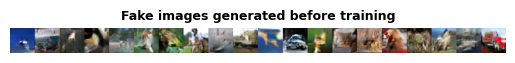

In [19]:
num_examples_to_generate = 20

random_vector_for_generation = tf.random.normal([num_examples_to_generate, latent_dim])
condition_vector_generation = tf.one_hot(list(range(10)) + list(range(10)), 10)

fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
fake_concat = np.transpose(img_to_uint8(fake), [1, 0, 2, 3]).reshape((32, -1, 3))
plt.imshow(fake_concat)
plt.title(f'Fake images generated before training', fontsize=9, fontweight='bold'), plt.axis('off')
plt.show()